In [1]:
#Importing Libraries
import numpy as np
import os
import pandas as pd
from numpy import array
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import re
import num2words
from tensorflow.keras import backend
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, concatenate,BatchNormalization, Activation
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Conv1D,MaxPooling1D, Bidirectional, GRU
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from itertools import combinations

%matplotlib inline

Using TensorFlow backend.


### 1. Import Files 

In [2]:
local_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons'
files_path = []
# r=root, d=directories, f = files
for r, d, f in os.walk(local_path):
    for file in f:
        if '.xlsx' in file:
            files_path.append(os.path.join(r, file))
            
n_files = len(files_path)
print('Number of Files: '+str(n_files))

Number of Files: 11


In [3]:
dfs = []
for path in files_path:
    df = pd.read_excel(path)
    df = df[np.isfinite(df['Phase'])]
    df['Phase'] = df['Phase'].astype(int)-1
    df['Utterance'] = df['Utterance'].apply(lambda row: re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), row))
    df['Utterance'] = df['Utterance'].apply(lambda row: row.replace('?',' ?'))
    dfs.append(df)
docs_size = pd.Series([df.shape[0] for df in dfs])
dfs[0].head()

,StudentID,Student,time_start,time_end,Phase,Phase_start,Phase_end,Utterance
0,O2,NaN,NaN,NaN,0,1.0,NaN,Satunnaiskävely.
1,O1,NaN,NaN,NaN,0,NaN,NaN,[lukee tehtävänantoa]
2,O1,NaN,NaN,NaN,0,NaN,1.0,Voi voi. [käynnistää videon]
3,O1,NaN,NaN,NaN,0,1.0,NaN,"Missä se vaeltaa siellä ? Onks se, ei. Ei, se ..."
4,O2,NaN,NaN,NaN,0,NaN,NaN,[epäselvä]


### 2. Preprocessing of Data 

In [4]:
#Fitting the Tokenizer on the docs:
docs = [' '.join(list(df['Utterance'].astype(str))) for df in dfs]
t = Tokenizer(filters='¡!"\'#$%&()*+,./:;<=>@[\\]^_`{|}~\t\n',num_words=2000)
t.fit_on_texts(docs)

In [5]:
#Add Previous and Next Utterance, Number of Words and Relative Position:
i = 1
max_length = 20
for df in dfs:
    print('Processing Document '+str(i))
    i+=1
    df['Relative Position'] = df.index/len(df)
    df['Number of Words'] = df.apply(lambda row: len(row['Utterance'].split()), axis = 1)
    df['Number of Words'] = df['Number of Words']/df['Number of Words'].max()
    df['Tokenized Utterance'] = df.apply(lambda row: t.texts_to_sequences([str(row['Utterance'])])[0], axis = 1)
    df['Previous Tokenized Utterance'] = df['Tokenized Utterance'].shift(1)
    df['Next Tokenized Utterance'] = df['Tokenized Utterance'].shift(-1)
    df = df.dropna()
print('Done!')

Processing Document 1
Processing Document 2
Processing Document 3
Processing Document 4
Processing Document 5
Processing Document 6
Processing Document 7
Processing Document 8
Processing Document 9
Processing Document 10
Processing Document 11
Done!


In [9]:
#Join and Pad Secuences

all_data = pd.concat(dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Phase']].dropna()

X = np.concatenate((pad_sequences(all_data['Tokenized Utterance'],maxlen=max_length ,padding='post'),
                 pad_sequences(all_data['Previous Tokenized Utterance'],maxlen=max_length ,padding='post'),
                 pad_sequences(all_data['Next Tokenized Utterance'],maxlen=max_length ,padding='post')), axis=1)
X_r = np.array(all_data['Relative Position'])
X_n = all_data['Number of Words']

X = np.column_stack((X, X_r)) 
X = np.column_stack((X, X_n))

y = keras.utils.to_categorical(all_data['Phase'], num_classes=5, dtype='float32')

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#Training set and Test Set Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#Split Training and Test Set
documents_numbers = range(11)
couple = {0,1}

#Split Training and Test Set
training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Phase']].dropna()
X_train = np.concatenate((pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post'),
                 pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post'),
                 pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')), axis=1)
X_r_train = all_data_train['Relative Position']
X_n_train = all_data_train['Number of Words']
X_train = np.column_stack((X_train, X_r_train)) 
X_train = np.column_stack((X_train, X_n_train))
y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')
    
test_dfs = [dfs[i] for i in couple]
all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Phase']].dropna()
X_test = np.concatenate((pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post'),
                 pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post'),
                 pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')), axis=1)
X_r_test = all_data_test['Relative Position']
X_n_test = all_data_test['Number of Words']
X_test = np.column_stack((X_test, X_r_test)) 
X_test = np.column_stack((X_test, X_n_test))
y_test = keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32')

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


### 3.1 Trainable Embeddings Full Model:

In [13]:
#Main input (Utterances)
vocab_size = 10000
main_input = Input(shape=(max_length*3,), dtype='int32', name='main_input')
#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')
#Embedding of the Utterances
x = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length*3)(main_input)
#x1 = Lambda(lambda x: K.sum(x[:,0:max_length-1], axis=1))(x)
#x2 = Lambda(lambda x: K.sum(x[:,max_length:(max_length*2)-1], axis=1))(x)
#x3 = Lambda(lambda x: K.sum(x[:,max_length*2:(max_length*3)-1], axis=1))(x)
#x = concatenate([x1,x2,x3,rel_position_input,n_words_input])
#attention layer 
x = Lambda(lambda x: K.sum(x, axis=1))(x)
#x = Dropout(0.2)(x)
x = concatenate([x,rel_position_input,n_words_input])
x = Dense(128, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
#x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.4)(x)
main_output = Dense(5, activation='softmax', name='main_output')(x)

model_1_full = Model(inputs=[main_input, rel_position_input,n_words_input], outputs=[main_output])

model_1_full.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_1_full.name = 'te'

model_1_full.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_1_full.name)+'.h5')

model_1_full.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/'+str(model_1_full.name)+'.h5')

In [14]:
model_1_full.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 200)      2000000     main_input[0][0]                 
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 200)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
rel_position_input (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
n_words_in

In [18]:
#Load Initial Random Weights:
model_1_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_1_full.name)+'.h5')

#Checkpoint:
checkpoint_1_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_1_full_random_split.h5', 
                             verbose=2, monitor='val_acc',save_best_only=True, mode='auto')

#Fit the Model:
history = model_1_full.fit({'main_input': X_train[:,:-2], 'rel_position_input': X_train[:,-2],'n_words_input':X_train[:,-1]},
          {'main_output': y_train}, validation_data= ({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
            'n_words_input':X_test[:,-1]},{'main_output': y_test}),epochs=10, batch_size=64,
            shuffle=True, callbacks = [checkpoint_1_full], verbose = 2)

Train on 1566 samples, validate on 392 samples
Epoch 1/10
 - 2s - loss: 1.3175 - acc: 0.4693 - val_loss: 1.0956 - val_acc: 0.5663

Epoch 00001: val_acc improved from -inf to 0.56633, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_1_full_random_split.h5
Epoch 2/10
 - 2s - loss: 0.8124 - acc: 0.7197 - val_loss: 0.8389 - val_acc: 0.6786

Epoch 00002: val_acc improved from 0.56633 to 0.67857, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_1_full_random_split.h5
Epoch 3/10
 - 2s - loss: 0.4967 - acc: 0.8186 - val_loss: 0.6954 - val_acc: 0.7755

Epoch 00003: val_acc improved from 0.67857 to 0.77551, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_1_full_random_split.h5
Epoch 4/10
 - 3s - loss: 0.2929 - acc: 0.9074 - val_loss: 0.7075 - val_acc: 0.7781

Epoch 00004: val_acc improved from 0.77551 to 0.77806, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_1_full_random_s

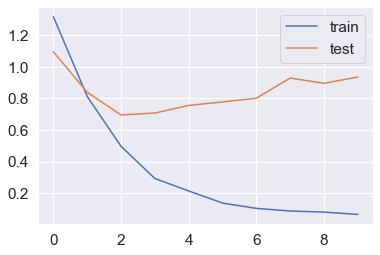

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

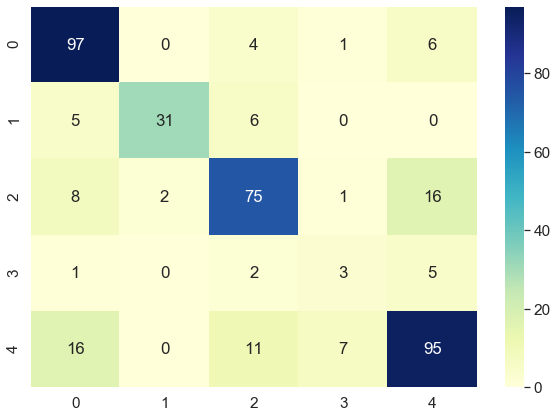

In [17]:
y_real = y_test.argmax(axis=-1)
y_pred = model_1_full.predict({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
                               'n_words_input':X_test[:,-1]}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

### 3.2 Trained Embeddings Full Model:

In [8]:
#Load the Embeddings
from gensim.models import KeyedVectors
path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/finnish_4B_parsebank_skgram.bin'
wv = KeyedVectors.load_word2vec_format(path,binary=True, encoding='UTF-8',limit=500000,unicode_errors='replace') 

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [9]:
#Build the Embedding Matrix
max_vocab = 10000
embedding_matrix = np.zeros((max_vocab, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = wv.get_vector(word)
        embedding_matrix[i] = embedding_vector
    except:
        pass  

In [38]:
#Main input (Utterances)
main_input = Input(shape=(60,), dtype='int32', name='main_input')
#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')
#Embedding of the Utterances
x = Embedding(output_dim=200, input_dim=vocab_size, input_length=60,weights=[embedding_matrix],trainable=False)(main_input)
#x1 = Lambda(lambda x: K.sum(x[:,0:max_length-1], axis=1))(x)
#x2 = Lambda(lambda x: K.sum(x[:,max_length:(max_length*2)-1], axis=1))(x)
#x3 = Lambda(lambda x: K.sum(x[:,max_length*2:(max_length*3)-1], axis=1))(x)
#x = concatenate([x1,x2,x3,rel_position_input,n_words_input])
x = Lambda(lambda x: K.sum(x, axis=1))(x)
#x = Dropout(0.2)(x)
x = concatenate([x,rel_position_input,n_words_input])
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.4)(x)
main_output = Dense(5, activation='softmax', name='main_output')(x)
model_2_full = Model(inputs=[main_input, rel_position_input,n_words_input], outputs=[main_output])
model_2_full.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2_full.name = 'pe'

model_2_full.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_2_full.name)+'.h5')

model_2_full.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/'+str(model_2_full.name)+'.h5')


In [39]:
model_2_full.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 60, 200)      2000000     main_input[0][0]                 
__________________________________________________________________________________________________
lambda_40 (Lambda)              (None, 200)          0           embedding_12[0][0]               
__________________________________________________________________________________________________
rel_position_input (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
n_words_in

In [54]:
#Load Initial Random Weights:
model_2_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_2_full.name)+'.h5')

#Checkpoint
checkpoint_2_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_2_full_random_split.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')
#Fit the model
history = model_2_full.fit({'main_input': X_train[:,:-2], 'rel_position_input': X_train[:,-2],'n_words_input':X_train[:,-1]},
          {'main_output': y_train}, validation_data= ({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
            'n_words_input':X_test[:,-1]},{'main_output': y_test}),epochs=30, batch_size=64,
            shuffle=True, callbacks = [checkpoint_2_full])

Train on 1412 samples, validate on 546 samples
Epoch 1/30
1412/1412 [==============================] - 7s 5ms/step - loss: 1.5270 - acc: 0.4292 - val_loss: 1.5064 - val_acc: 0.3956

Epoch 00001: val_acc improved from -inf to 0.39560, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_2_full_random_split.h5
Epoch 2/30
1412/1412 [==============================] - 0s 200us/step - loss: 1.1497 - acc: 0.5715 - val_loss: 1.2491 - val_acc: 0.5000

Epoch 00002: val_acc improved from 0.39560 to 0.50000, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_2_full_random_split.h5
Epoch 3/30
1412/1412 [==============================] - 0s 203us/step - loss: 1.0395 - acc: 0.6339 - val_loss: 1.3023 - val_acc: 0.4469

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/30
1412/1412 [==============================] - 0s 210us/step - loss: 0.9348 - acc: 0.6445 - val_loss: 1.3095 - val_acc: 0.4817

Epoch 00004: val_acc did not improve from 0.50

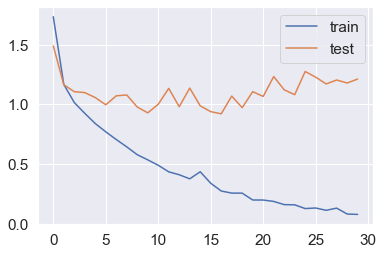

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

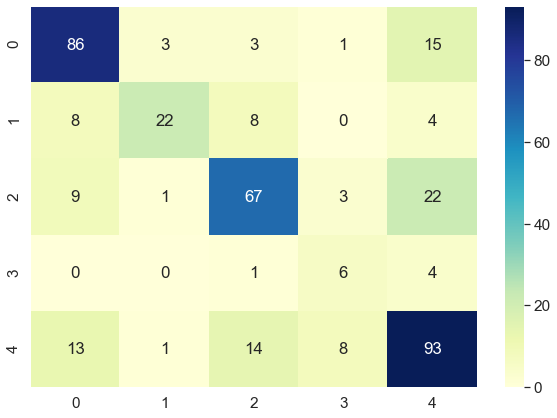

In [30]:
y_real = y_test.argmax(axis=-1)
y_pred = model_2_full.predict({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
                               'n_words_input':X_test[:,-1]}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

In [134]:
#Main input (Utterances)
main_input = Input(shape=(max_length,), dtype='int32', name='main_input')
#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')
#Embedding of the Utterances
x = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length,weights=[embedding_matrix],trainable=True)(main_input)
#x1 = Lambda(lambda x: K.sum(x[:,0:max_length-1], axis=1))(x)
#x2 = Lambda(lambda x: K.sum(x[:,max_length:(max_length*2)-1], axis=1))(x)
#x3 = Lambda(lambda x: K.sum(x[:,max_length*2:(max_length*3)-1], axis=1))(x)
#x = concatenate([x1,x2,x3,rel_position_input,n_words_input])
x = Lambda(lambda x: K.sum(x, axis=1))(x)
x = concatenate([x,rel_position_input,n_words_input])
x = Dense(128, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
main_output = Dense(5, activation='softmax', name='main_output')(x)
model_3_full = Model(inputs=[main_input, rel_position_input,n_words_input], outputs=[main_output])
model_3_full.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_3_full.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_3_full.h5')

In [135]:
model_3_full.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 75, 200)      2000000     main_input[0][0]                 
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 200)          0           embedding_32[0][0]               
__________________________________________________________________________________________________
rel_position_input (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
n_words_in

In [136]:
#Load Initial Random Weights:
model_3_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_3_full.h5')

#Checkpoint
checkpoint_3_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_3_full_random_split.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')
#Fit the model
history = model_3_full.fit({'main_input': X_train[:,:-2], 'rel_position_input': X_train[:,-2],'n_words_input':X_train[:,-1]},
          {'main_output': y_train}, validation_data= ({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
            'n_words_input':X_test[:,-1]},{'main_output': y_test}),epochs=20, batch_size=64,
            shuffle=True, callbacks = [checkpoint_3_full])

Train on 1412 samples, validate on 546 samples
Epoch 1/20
1412/1412 [==============================] - 15s 11ms/step - loss: 1.5304 - acc: 0.4235 - val_loss: 1.3205 - val_acc: 0.4817

Epoch 00001: val_acc improved from -inf to 0.48168, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_3_full_random_split.h5
Epoch 2/20
1412/1412 [==============================] - 2s 1ms/step - loss: 1.0102 - acc: 0.6268 - val_loss: 1.2460 - val_acc: 0.4835

Epoch 00002: val_acc improved from 0.48168 to 0.48352, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_3_full_random_split.h5
Epoch 3/20
1412/1412 [==============================] - 2s 1ms/step - loss: 0.7778 - acc: 0.7337 - val_loss: 1.2488 - val_acc: 0.5256

Epoch 00003: val_acc improved from 0.48352 to 0.52564, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/model_3_full_random_split.h5
Epoch 4/20
1412/1412 [==============================] - 2s 2ms/step - loss: 0.

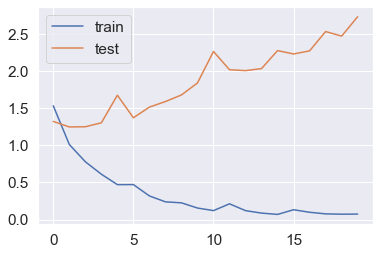

In [137]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 3.3 Encoder Model:

In [10]:
#Main input (Utterances)
vocab_size = 10000
max_length = 20
main_input = Input(shape=(max_length*3,), dtype='int32', name='main_input')
#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')
#Embedding of the Utterances
x = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length*3,weights=[embedding_matrix],trainable=False)(main_input)

x = Bidirectional(LSTM(20, return_sequences = True))(x)

x = Bidirectional(LSTM(20))(x)

x = concatenate([x,rel_position_input,n_words_input])
x = Dense(64, activation='relu')(x)

main_output = Dense(5, activation='softmax', name='main_output')(x)


model_6_full = Model(inputs=[main_input, rel_position_input,n_words_input], outputs=[main_output])
model_6_full.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_6_full.name = 'pe_encoder'

model_6_full.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_6_full.name)+'.h5')

model_6_full.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_6_full.name)+'.h5')


In [11]:
model_6_full.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 200)      2000000     main_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 40)       35360       embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 40)           9760        bidirectional_1[0][0]            
__________________________________________________________________________________________________
rel_positi

In [13]:
#Load Initial Random Weights:
model_6_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_6_full.name)+'.h5')

#Checkpoint
checkpoint_6_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_6_full.name)+'_testing.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')


history = model_6_full.fit({'main_input': X_train[:,:-2], 'rel_position_input': X_train[:,-2],'n_words_input':X_train[:,-1]},
          {'main_output': y_train}, validation_data= ({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
            'n_words_input':X_test[:,-1]},{'main_output': y_test}),epochs=30, batch_size=64,
            shuffle=True, callbacks = [checkpoint_6_full])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1412 samples, validate on 546 samples
Epoch 1/30
1412/1412 [==============================] - 24s 17ms/step - loss: 1.4907 - acc: 0.3605 - val_loss: 1.3475 - val_acc: 0.3956

Epoch 00001: val_acc improved from -inf to 0.39560, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_encoder_testing.h5
Epoch 2/30
1412/1412 [==============================] - 13s 9ms/step - loss: 1.3681 - acc: 0.4292 - val_loss: 1.2594 - val_acc: 0.4780

Epoch 00002: val_acc improved from 0.39560 to 0.47802, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pe_encoder_testing.h5
Epoch 3/30
1412/1412 [==============================] - 13s 9ms/step - loss: 1.2807 - acc: 0.4625 - val_loss: 1.2155 - val_acc: 0.4744

Epoch 00003: val_acc did not improve from 0.47802
Epoch 4/30
1412/1412 [==============================] - 14s 10ms/step - loss: 1.2081 - acc: 0.4936 - va

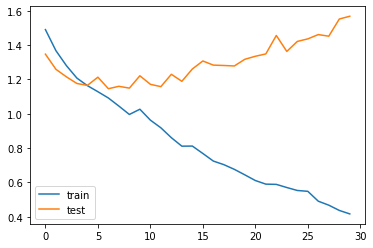

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

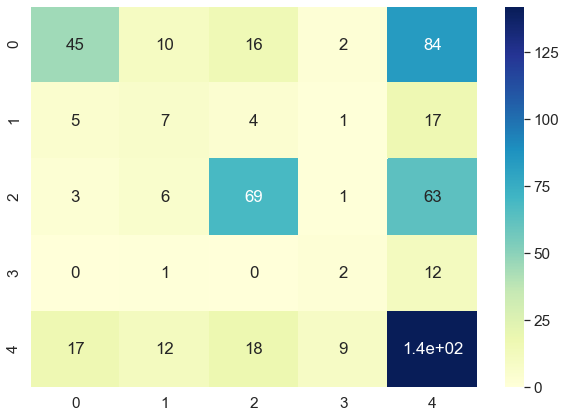

In [23]:
y_real = y_test.argmax(axis=-1)
y_pred = model_4_full.predict({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
                               'n_words_input':X_test[:,-1]}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

In [25]:
comparative = pd.DataFrame()
comparative['x'] = list(X_test[:,:-2])
comparative['GT'] = y_test.argmax(axis=-1)
comparative['Model 2 Pred'] = model_2_full.predict({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
                               'n_words_input':X_test[:,-1]}).argmax(axis=-1)
comparative['Model 4 Pred'] = model_4_full.predict({'main_input': X_test[:,:-2], 'rel_position_input': X_test[:,-2],
                               'n_words_input':X_test[:,-1]}).argmax(axis=-1)

NameError: name 'model_2_full' is not defined

In [59]:
comparative.loc[(comparative['Model 4 Pred'] == comparative['GT'])].head()

,x,GT,Model 2 Pred,Model 4 Pred
0,"[152.0, 354.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0,0,0
4,"[1531.0, 17.0, 15.0, 2.0, 94.0, 4.0, 1.0, 7.0,...",0,0,0
5,"[355.0, 14.0, 254.0, 2.0, 444.0, 392.0, 143.0,...",0,0,0
6,"[1532.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0,4,0
9,"[152.0, 354.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0,0,0
